# 1 Data Wrangling and EDA

## 1.1 Preparation

### 1.1.1 Importing Packages

In [1]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import shutil

### 1.1.2 Loading Metadata

In [2]:
# Loading data
data = pd.read_csv('../data/raw/Data_Entry_2017_v2020.csv')
data.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


## 1.2 Labeling Data

In [3]:
# Label Cardiomegaly if 'Finding Labels' contains 'Cardiomegaly'
data['Cardiomegaly'] = data['Finding Labels'].str.contains('Cardiomegaly')

In [4]:
# Determine value counts for labels
data.value_counts('Cardiomegaly')

Cardiomegaly
False    109344
True       2776
Name: count, dtype: int64

In [5]:
data.value_counts('Cardiomegaly', normalize=True) * 100

Cardiomegaly
False    97.524081
True      2.475919
Name: proportion, dtype: float64

Only 2.48% of the images are diagnosed with cardiomegaly, which is 2776 of the 112,120 images.

## 1.3 Exploring the data

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Cardiomegaly                 112120 non-null  bool   
dtypes: bool(1), float64(2), int64(5), object(4)
memory usage: 

In [7]:
# Check missing values
data.isna().sum()

Image Index                    0
Finding Labels                 0
Follow-up #                    0
Patient ID                     0
Patient Age                    0
Patient Gender                 0
View Position                  0
OriginalImage[Width            0
Height]                        0
OriginalImagePixelSpacing[x    0
y]                             0
Cardiomegaly                   0
dtype: int64

There are no missing values in the data.

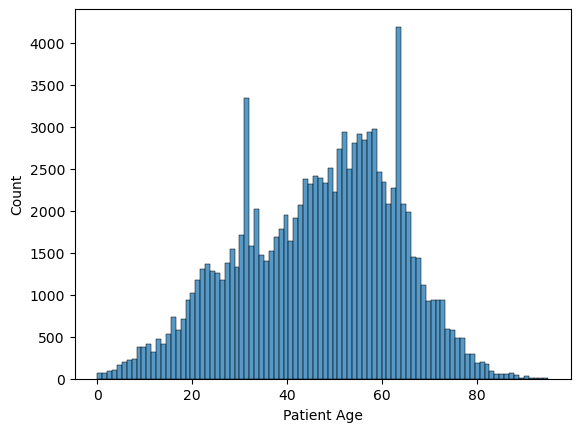

In [8]:
# View ages of patients
sns.histplot(data=data, x='Patient Age');

The majority of patients are between 50-60 years old.

In [9]:
def plot_proportion(df, col):
    """Plots the proportion of a category 'col' for each class in 'Cardiomegaly'."""
    x, y, hue = col, "Proportion", "Cardiomegaly"
    hue_order = [True, False]

    (df[x]
     .groupby(df[hue])
     .value_counts(normalize=True)
     .rename(y)
     .reset_index()
     .pipe((sns.barplot, "data"), x=x, y=y, hue=hue));

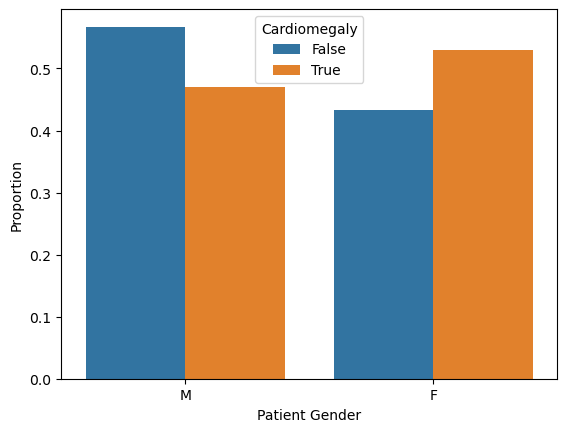

In [10]:
# Plot the proportion for Patient Gender
plot_proportion(data, 'Patient Gender')

Of patients with cardiomegaly, there is a higher percentage of female patients than male while for negative patients, there are more male patients. In both cases, the difference between the proportions is roughly 10%.

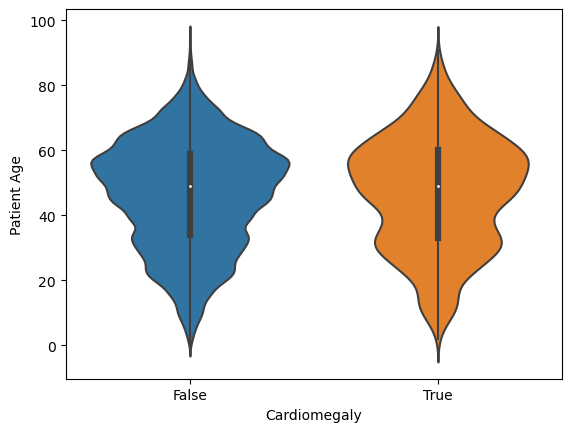

In [11]:
# Plot a violin plot for Patient Age separated by Cardiomegaly
sns.violinplot(data=data, y='Patient Age', x='Cardiomegaly');

The distributions of patient age are virtually identical between patients with and without cardiomegaly.

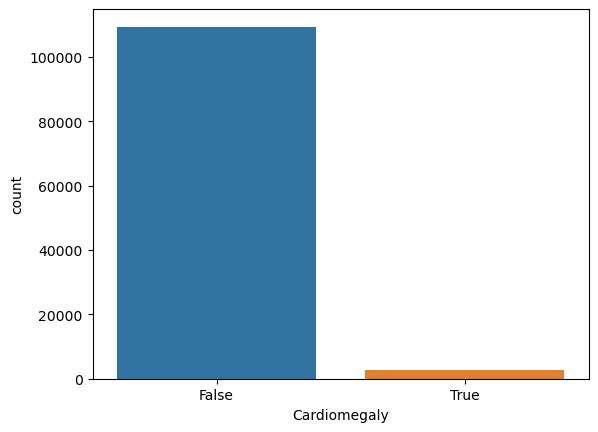

In [12]:
# Plot counts for Cardiomegaly
sns.countplot(data=data, x='Cardiomegaly');

The dataset is highly imbalanced towards images without cardiomegaly.

## 1.4 Undersampling
Due to the large number of images and high class imbalance, I undersampled the data, taking all Cardiomegaly samples and an equal number of negative samples.

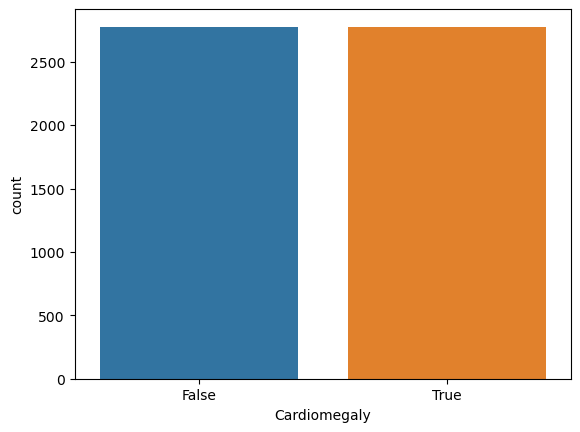

In [13]:
sampled_data = data.groupby("Cardiomegaly").sample(n=2776, random_state=1)
sns.countplot(data=sampled_data, x='Cardiomegaly');

I now have a DataFrame with 2776 images of each positive and negative classes.

## 1.5 Training and Validation Sets
To prepare the data for the Keras ImageDataGenerator, I created training and testing set folders with the sampled images.

In [14]:
cardiomegaly = sampled_data.loc[sampled_data['Cardiomegaly']==True]
noncardiomegaly = sampled_data.loc[sampled_data['Cardiomegaly']==False]

In [15]:
cardiomegaly_train, cardiomegaly_split = train_test_split(cardiomegaly,
                                                         test_size=0.4,
                                                         random_state=46)
noncardiomegaly_train, noncardiomegaly_split = train_test_split(noncardiomegaly,
                                                         test_size=0.4,
                                                         random_state=46)

In [16]:
cardiomegaly_test, cardiomegaly_validation = train_test_split(cardiomegaly_split,
                                                         test_size=0.5,
                                                         random_state=84)
noncardiomegaly_test, noncardiomegaly_validation = train_test_split(noncardiomegaly_split,
                                                         test_size=0.5,
                                                         random_state=84)

In [17]:
cardiomegaly_500 = cardiomegaly_train.sample(n=500, random_state=7)
noncardiomegaly_500 = noncardiomegaly_train.sample(n=500, random_state=8)

In [18]:
cardiomegaly_500_train, cardiomegaly_500_validation = train_test_split(cardiomegaly_500,
                                                         test_size=0.2,
                                                         random_state=46)
noncardiomegaly_500_train, noncardiomegaly_500_validation = train_test_split(noncardiomegaly_500,
                                                         test_size=0.2,
                                                         random_state=46)

In [19]:
def copy_images(folder, df, train_test_split, label):
    old_directory = '../data/raw/all_images'
    new_directory = os.path.join(os.path.join(os.path.join('../data/processed', folder), train_test_split), label)
    for img in df['Image Index']:
        old_path = os.path.join(old_directory, img)
        new_path = os.path.join(new_directory, img)
        shutil.copyfile(old_path, new_path)

In [20]:
copy_images('full', cardiomegaly_train, 'train', 'cardiomegaly')
copy_images('full', cardiomegaly_test, 'test', 'cardiomegaly')
copy_images('full', cardiomegaly_validation, 'validation', 'cardiomegaly')
copy_images('full', noncardiomegaly_train, 'train', 'noncardiomegaly')
copy_images('full', noncardiomegaly_test, 'test', 'noncardiomegaly')
copy_images('full', noncardiomegaly_validation, 'validation', 'noncardiomegaly')

In [21]:
copy_images('partial', cardiomegaly_500_train, 'train', 'cardiomegaly')
copy_images('partial', cardiomegaly_500_validation, 'validation', 'cardiomegaly')
copy_images('partial', noncardiomegaly_500_train, 'train', 'noncardiomegaly')
copy_images('partial', noncardiomegaly_500_validation, 'validation', 'noncardiomegaly')

## 1.6 Visualizing Cardiomegaly

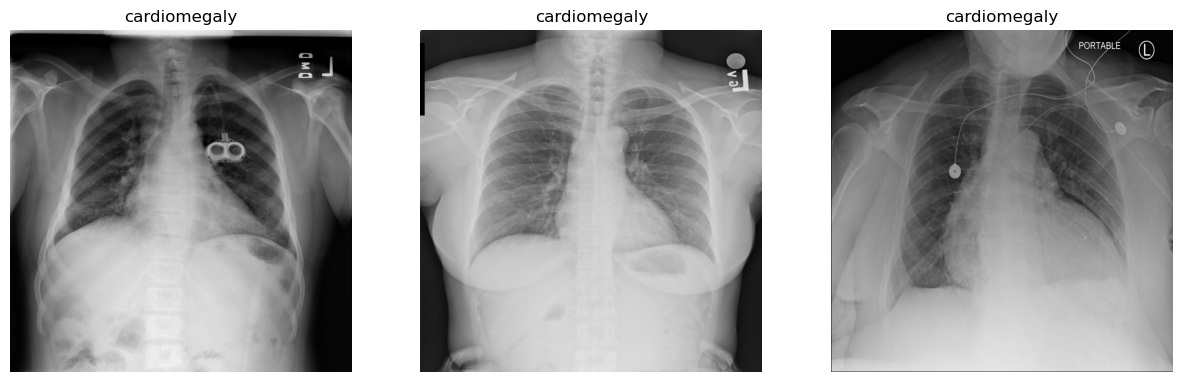

In [22]:
# Plot 3 examples with cardiomegaly
positive_examples = cardiomegaly_train.iloc[:3,0]

image_directory = "../data/raw/all_images"

fig, axes = plt.subplots(1, 3, figsize=(15,8))
for ax, image in zip(axes, positive_examples):
    with Image.open(os.path.join(image_directory, image)) as f:
        im = f
        ax.imshow(im, cmap='gray', vmin=0, vmax=255)
        ax.axis('off')
        ax.set_title('cardiomegaly')
plt.show()

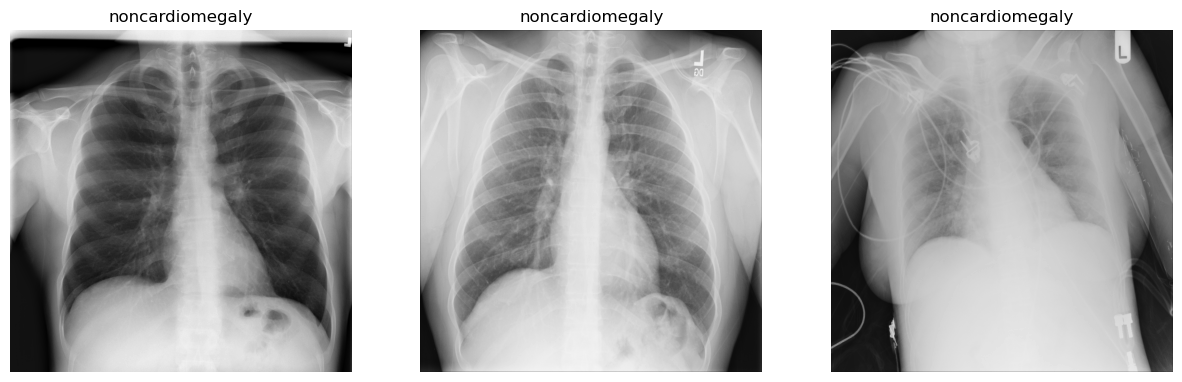

In [23]:
# Plot 3 examples without cardiomegaly
negative_examples = noncardiomegaly_train.iloc[:3,0]

fig, axes = plt.subplots(1, 3, figsize=(15,8))
for ax, image in zip(axes, negative_examples):
    with Image.open(os.path.join(image_directory, image)) as f:
        im = f
        ax.imshow(im, cmap='gray', vmin=0, vmax=255)
        ax.axis('off')
        ax.set_title('noncardiomegaly')
plt.show()